# Average Bubble Profile

In [31]:
import numpy as np
import math
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
import scipy.interpolate as intp
import statistics as stat
import random
from functools import partial
from operator import eq
from itertools import zip_longest, compress, count, islice, groupby, cycle
#from labellines import labelLine, labelLines
import os
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [32]:
nLat = 4096
nSims = 100
lSims = 0

nu = 2.*10**(-3)
lamb = 1.5; print('lamb = ', lamb)
m2eff = 4. * nu * (- 1. + lamb**2); print('m2eff = ', m2eff)
lenLat = 2 * 50. / np.sqrt(2. * nu); print('lenLat = ', lenLat)
phi0 = 2. * np.pi / 4.; print('phi0 = ', phi0)

alpha = 8.
nCols = 1
phi_initial = np.pi
dt_phi_initial = 0.
mask = 4*phi_initial

############################################################
nyq = nLat//2+1
spec = nyq
hLat = nLat//2
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha
light_cone = dtout/dx

lamb =  1.5
m2eff =  0.01
lenLat =  1581.1388300841897
phi0 =  1.5707963267948966


In [34]:
3000*dtout*np.sqrt(0.008)

103.58009490037318

In [30]:
list_phi0 = np.asarray([2*np.pi/6.6, 2*np.pi/7., 2*np.pi/6.6])
print(list_phi0*np.sqrt(2))

[1.34632816 1.26939513 1.34632816]


In [4]:
titles = [r'$\phi(x)$', r'$\partial_t \phi(x)$', r'$|\nabla \phi(x)|^2$', r'$V(\phi(x))$']
plots_file = '/home/dpirvu/big_plot_file/thick_wall_average_bubble/'
pickle_location = '/home/dpirvu/pickle_location/thick_wall_average_bubble/'
cutout_location = '/gpfs/dpirvu/thick_wall_average_bubble/'
suffix = '_for_phi0{:.4f}'.format(phi0)+'_lambda'+str(lamb)+'_len{:.4f}'.format(lenLat)+'_x'+str(nLat)

def bubbles_file(min, max):
    return cutout_location+'bubbles_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def centred_bubbles_file(min, max):
    return pickle_location+'centred_bubbles_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def bubbles_at_rest_file(sim):
    return cutout_location+'restbubble_sim'+str(sim)+suffix+'.npy'
def average_bubble(min, max):
    return pickle_location+'average_bubble_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def new_bubble_data(min, max):
    return pickle_location+'bubbles_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def new_full_bubble_data(min, max):
    return cutout_location+'rest_bubbles_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
def average_of_N_bubbles(Nbubbles):
    return pickle_location+'average_of_'+str(Nbubbles)+'_bubbles'+suffix+'.npy'

filter_size =  50.64720254541112


Text(0, 0.5, '$\\phi$')

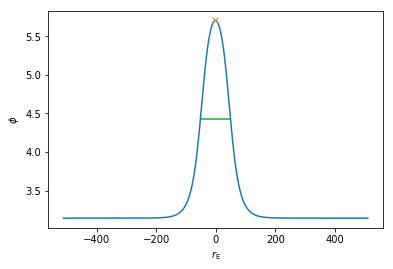

In [5]:
instanton_location = '/home/dpirvu/inst/instantons/dev/thick_wall_instanton_sim.dat'
a = np.genfromtxt(instanton_location)
coleman_profile = np.pi+a[:,0]
xoffset = nLat//8
temp = coleman_profile[len(coleman_profile)//2-xoffset:len(coleman_profile)//2+xoffset]
peaks, _ = scs.find_peaks(temp)
fwhm, height, left_ips, right_ips = scs.peak_widths(temp, peaks, rel_height=0.5)
filter_size = max(fwhm)/2.; print('filter_size = ', filter_size)
radius_Coleman_bubble = filter_size*dx

plt.plot(np.arange(len(temp))-xoffset, temp)
plt.plot(peaks-xoffset, temp[peaks], "x")
[plt.hlines(height[i], left_ips[i]-xoffset, right_ips[i]-xoffset, color="C2") for i in range(len(fwhm))]
plt.xlabel(r'$r_{\rm E}$'); plt.ylabel(r'$\phi$')

wall_tension =  0.46497413771169294
epsilon =  0.016
R_coleman =  29.06088360698081
wall_thkn =  80.67292631362025


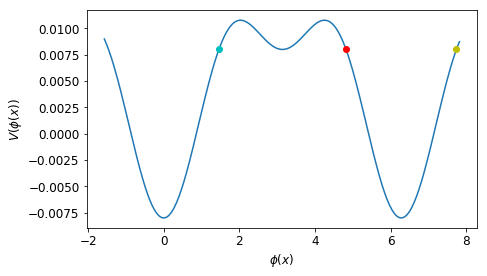

In [6]:
def V(phi):
    return ( -np.cos(phi) + 0.5 * lamb**2. * np.sin(phi)**2. ) * 4. * nu
def dV(phi):
    return ( np.sin(phi) + 0.5 * lamb**2. * np.sin(2.*phi) ) * 4. * nu

right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[np.pi, 2*np.pi], method='bounded')
left_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[0, np.pi], method='bounded')
right_left_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x), bounds=[2*np.pi, 3*np.pi], method='bounded')

def F(x):
    return V(x) - V(phi_initial)
phi_upper_bound = sco.fsolve(F, 5)[0]
phi_lower_bound = sco.fsolve(F, 1)[0]
phi_upper_lower_bound = sco.fsolve(F, 8)[0]

############################################################
wall_tension, err = sci.quad(lambda x: np.sqrt(2*(V(x) - V(2*np.pi))), np.pi, 2*np.pi); print('wall_tension = ', wall_tension)
epsilon = V(np.pi) - V(2*np.pi); print('epsilon = ', epsilon)
R_coleman = wall_tension/epsilon; print('R_coleman = ', R_coleman)
wall_thkn = right_phi_at_V_max.x / np.sqrt( V(right_phi_at_V_max.x) - V(np.pi) ); print('wall_thkn = ', wall_thkn)
############################################################

matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(7, 4))
plt.plot([i for i in np.arange(-np.pi/2, 5*np.pi/2, np.pi/100)], [V(i) for i in np.arange(-np.pi/2, 5*np.pi/2, np.pi/100)])
plt.plot(phi_upper_bound, V(phi_upper_bound), 'ro')
plt.plot(phi_lower_bound, V(phi_lower_bound), 'co')
plt.plot(phi_upper_lower_bound, V(phi_upper_lower_bound), 'yo')
plt.xlabel(r'$\phi(x)$'); plt.ylabel(r'$V(\phi(x))$'); plt.show()

### VISUALISING SIMULATION DATA

In [ ]:
all_data, sims_to_keep = np.load(bubbles_file(0, nSims))
normal = [phi_initial, np.mean([sim[1][0] for sim in all_data]), np.mean([sim[2][0] for sim in all_data]), V(phi_initial), np.mean([0.5*sim[1][0]**2 for sim in all_data])]

In [7]:
#normal = [phi_initial, 0, 0, V(phi_initial), 0]

In [8]:
def add_mask(field_slice, threshold):
    return field_slice * [0 if np.abs(i) > threshold else 1 for i in field_slice]

def find_slice_peaks(field_slice, peak_threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = signal.find_peaks(field_slice, height = peak_threshold)[0].tolist()
    if field_slice[-1] > peak_threshold and field_slice[0] > peak_threshold and field_slice[-1] != field_slice[0]:
        if field_slice[0] > field_slice[-1] and field_slice[0] > field_slice[1]:
            peak_coord.append(0)
        elif field_slice[0] < field_slice[-1] and field_slice[-1] > field_slice[-2]:
            peak_coord.append(len(field_slice)-1) # this minds potential boundary discontinuities
    peak_heights = [field_slice[coord] for coord in peak_coord]
    return peak_coord, field_slice.tolist().index(np.max(peak_heights))

def truncateNum(num, decimal_places):
    StrNum = str(num)
    p = StrNum.find(".") + 1 + decimal_places
    return float(StrNum[0:p])

def time_at_fraction(bubble, frac, limit):
    T, N = len(bubble), len(bubble[0])
    right_phi_x = [np.sum([1 for x in slice if mask > x >= limit]) for slice in bubble]
    time_list = [t if (right_phi_x[t] <= N*frac) else 0 for t in range(T)]
    return next((t for t in time_list[::-1] if t != 0), 0)

def time_at_size(bubble, size, limit):
    T, N = len(bubble), len(bubble[0])
    right_phi_x = [np.sum([1 for x in slice if mask > x >= limit]) for slice in bubble]
    time_list = [t if (right_phi_x[t] <= size) else 0 for t in range(T)]
    return next((t for t in time_list[::-1] if t != 0), T-1)

def center_bubble(bubble):
    bubble0 = bubble[0]
    #truncate bubble where it expands relativistically
    limit = phi_upper_bound
    tdecap = time_at_fraction(bubble0, 0.6, limit)
    T, N = len(bubble0), len(bubble0[0])

    tcheck = time_at_fraction(bubble0, 0.02, 2*phi_initial)
    slice = gaussian_filter1d(bubble0[tcheck], sigma=1)
    xmax = slice.tolist().index(max(slice))
    angle = int(N//2) - xmax # rotation angle needed
    print(angle)
    bubble = np.asarray([[np.roll(bubble[col][t], angle) for t in range(tdecap)] for col in range(len(bubble))])

    # check which sides the COM travels
    slice = gaussian_filter1d(bubble[0][tcheck], sigma=1)
    xmax = slice.tolist().index(max(slice))
    xlist = np.arange(nLat//2-500, xmax+500)%nLat
    fld = [[bubble[0][t][x] for x in xlist] for t in range(tcheck-100, tcheck, 2)]
    tv = [np.nanmean([x for x in range(len(fld[0])) if fld[t][x] > np.ceil(limit)]) for t in range(len(fld))]
    decr = np.sum([1 for i, j in zip(tv, tv[1::]) if i >= j])
    incr = np.sum([1 for i, j in zip(tv, tv[1::]) if i < j])
    print('tcheckm, xmax, incr, decr ', tcheck, xmax, incr, decr)
    return bubble, decr - incr #np.nanmean(tv) - N//2

def multiply_bubble(bubble, dir, fold):
    bubble0 = bubble[0]
    T, N = len(bubble0), len(bubble0[0])
    bubble = [np.tile(bubble[col], fold) for col in range(len(bubble))] # multiplies bubbles so tail is kept without pbc
    TT, NN = len(bubble[0]), len(bubble[0][0])
    for t in range(TT):
        a, b = int((TT-t)*light_cone) + N, int((TT-t)*light_cone/2) - N//4
        x1, x2 = np.arange(a, NN), np.arange(b)
        if dir < 0:
            x1, x2 = x1 - a, x2 - (b-NN)
        for x in np.append(x1, x2):
            if 0 <= x < NN:
                bubble[0][t][x] = phi_initial
    return np.asarray(bubble)

In [9]:
for sim in range(len(all_data))[:5:]:
    print(sim)
    col = 0
    simulation = all_data[sim]
    centered, dir = center_bubble(simulation)
    mult = multiply_bubble(centered, dir, 2)
    fig, ax = plt.subplots(1, 3, figsize = (12, 3))
    im0 = ax[0].imshow(simulation[col], aspect='auto', interpolation='none', origin='lower')
    im1 = ax[1].imshow(centered[col], aspect='auto', interpolation='none', origin='lower')
    im2 = ax[2].imshow(mult[col], aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im0, ax = ax[0]); clb = plt.colorbar(im1, ax = ax[1]); clb = plt.colorbar(im2, ax = ax[2]); plt.show()

NameError: name 'all_data' is not defined

In [22]:
def rapidity(vel):
    return np.arctanh(vel)
def gamma(v):
    return ( 1. - v**2. )**(-0.5)

def tanh_pos(x, r0L, r0R, dr, vL, vR):
    wL, wR = dr/gamma(vL), dr/gamma(vR)
    return ( np.tanh( (x - r0L)/wL ) + np.tanh( (r0R - x)/wR ) ) * np.pi/2 + np.pi
def tanh_neg(x, r0L, r0R, dr, vL, vR):
    wL, wR = dr/gamma(vL), dr/gamma(vR)
    return - ( np.tanh( (x - r0L)/wL ) + np.tanh( (r0R - x)/wR ) ) * np.pi/2 + np.pi

def tanh_fit(bubble_slice, axis, prior):
#    plt.plot(axis, bubble_slice, 'ro', axis, [tanh(r, *best_tanh) for r in axis], 'g'); plt.show()
    bounds = ((axis[0], 0, 0, 0, 0), (0, axis[-1], axis[-1], 1, 1))
    if prior is not None:
        if np.mean(bubble_slice) > phi_initial:
            return sco.curve_fit(tanh_pos, axis, bubble_slice, p0=prior, bounds=bounds)[0]
        else:
            return sco.curve_fit(tanh_neg, axis, bubble_slice, p0=prior, bounds=bounds)[0]            
    else:
        if np.mean(bubble_slice) > phi_initial:
            return sco.curve_fit(tanh_pos, axis, bubble_slice, bounds=bounds)[0]
        else:
            return sco.curve_fit(tanh_neg, axis, bubble_slice, bounds=bounds)[0]

def hyperbola1(t, a, b, c):
    return np.sqrt(c + (t - b)**2) + a
def hyperbola2(t, d, e, f):
    return - np.sqrt(f + (t - e)**2) + d

def hypfit_test(tt, rr, qq): # no parameters in common between left and right wall for hyperbolic curve fit
    try:
        if rr[0] <= rr[-1]:
            fit1, pcov1 = sco.curve_fit(hyperbola1, tt, rr, p0 = (min(rr), tt[rr.tolist().index(min(rr))], 1e4))
            fit2, pcov2 = sco.curve_fit(hyperbola2, tt, qq, p0 = (max(qq), tt[qq.tolist().index(max(qq))], 1e4))
        else:
            fit1, pcov1 = sco.curve_fit(hyperbola2, tt, rr, p0 = (max(rr), tt[rr.tolist().index(max(rr))], 1e4))
            fit2, pcov2 = sco.curve_fit(hyperbola1, tt, qq, p0 = (min(qq), tt[qq.tolist().index(min(qq))], 1e4))
        return True
    except (RuntimeError, TypeError):
        return False
    
def hypfit(tt, rr, qq): # no parameters in common between left and right wall for hyperbolic curve fit
    if rr[0] <= rr[-1]:
        fit1, pcov1 = sco.curve_fit(hyperbola1, tt, rr, p0 = (min(rr), tt[rr.tolist().index(min(rr))], 1e4))
        fit2, pcov2 = sco.curve_fit(hyperbola2, tt, qq, p0 = (max(qq), tt[qq.tolist().index(max(qq))], 1e4))
        traj1, traj2 = hyperbola1(tt, *fit1), hyperbola2(tt, *fit2)
    else:
        fit1, pcov1 = sco.curve_fit(hyperbola2, tt, rr, p0 = (max(rr), tt[rr.tolist().index(max(rr))], 1e4))
        fit2, pcov2 = sco.curve_fit(hyperbola1, tt, qq, p0 = (min(qq), tt[qq.tolist().index(min(qq))], 1e4))
        traj1, traj2 = hyperbola2(tt, *fit1), hyperbola1(tt, *fit2)
    print('hyperbolic trajectories fit: ', fit1, fit2)
    plt.plot(rr, tt, 'g-', qq, tt, 'r-', traj1, tt, 'y:', traj2, tt, 'b:') # plot the equation using the fitted parameters
    return tt, traj1, traj2

def get_velocities(tt, rrwallfit, llwallfit):
    #uu = wall travelling along with the com; vv = wall travelling against the com; aa = centre of mass velocity; bb = instantaneous velocity of wall
    uu = intp.splev(tt, intp.splrep(tt, rrwallfit), der=1)
    vv = intp.splev(tt, intp.splrep(tt, llwallfit), der=1)

    for i in range(len(uu)):
        if np.abs(uu[i]) > 1:
            uu[i] = np.sign(uu[i])*(1-np.abs(np.abs(uu[i])-1))
        if np.abs(vv[i]) > 1:
            vv[i] = np.sign(vv[i])*(1-np.abs(np.abs(vv[i])-1))
    for i in range(len(uu)):
        if str(uu[i]) == 'nan' :
            uu[i] = - np.sign(vv[-1])*0.999
        if str(vv[i]) == 'nan' :
            vv[i] = - np.sign(uu[-1])*0.999

    aa = ( 1 + uu*vv - np.sqrt( (-1 + uu**2)*(-1 + vv**2))) / ( uu + vv)
    bb = (-1 + uu*vv + np.sqrt( (-1 + uu**2)*(-1 + vv**2))) / (-uu + vv)
    return uu, vv, aa, bb#, ch1, ch2

def velocity(bubble, bool):
    T, N = len(bubble), len(bubble[0])
    limit = phi_upper_bound #phi_upper_bound# - 0.5*np.abs(phi_upper_bound-np.floor(phi_upper_bound))
    prior = None
    data_list = []
    err = 0

    # find where fit can begin
    window = int(N//10)
    if window > 100: window = 100

    tf = T-1
    endSlice = [i for i in range(N) if np.cos(bubble[tf][i]) > np.cos(limit)]
    if len(endSlice) == 0:
        return 'next'
    while endSlice[0] - window < 0 or endSlice[-1] + window >= N:
        tf -= 2
        endSlice = [i for i in range(N) if np.cos(bubble[tf][i]) > np.cos(limit)]
        if len(endSlice) == 0:
            return 'next'

    for t in range(tf, 0, -1):
        if len(data_list) == 0:
            peaks = endSlice
            target = int(np.round(np.nanmean(peaks)))
            coord_list = np.arange(peaks[0] - window, peaks[-1] + window)
        else:
            xrange = np.arange(data_list[-1][0]-window, data_list[-1][0]+window+1)
            if all(0 <= i < N for i in xrange) and any(np.cos(bubble[t][i]) > np.cos(limit) for i in xrange):
                peaks = [i for i in xrange if np.cos(bubble[t][i]) > np.cos(limit)]
            else:
                break
            target = int(np.round(np.nanmean(peaks)))
            coord_list = np.arange(target - int(np.round(np.abs(data_list[-1][1]))) - window, target + int(np.round(np.abs(data_list[-1][2]))) + window)

        coords = np.asarray([(bubble[t][i%N], int(i-target)) for i in coord_list])
        if err < 5:
            try:
                r0L, r0R, dr, vL, vR = tanh_fit(coords[:,0], coords[:,1], prior)
                prior = r0L, r0R, dr, vL, vR
                data_list.append([target, r0L, r0R, int(t)])
            except (RuntimeError, ValueError, TypeError):
                prior = None
                data_list.append([target, r0L + np.sign(data_list[-1][1]-data_list[0][1])*light_cone*(T/N), r0R + np.sign(data_list[-1][2]-data_list[0][2])*light_cone*(T/N), int(t)])
                err += 1
        else:
            break
    data_list = np.asarray(data_list[::-1])
    targets, r0Ls, r0Rs, time_list = data_list[:,0], data_list[:,1], data_list[:,2], data_list[:,-1]
    print('tmin, tmax', time_list[0], time_list[-1])

    # get direction of bubble
    radius_diff = np.mean([np.abs(data_list[i,1]) - np.abs(data_list[i,2]) for i in range(len(data_list)//4)])
    if radius_diff > 0:  # if average difference in radius is positive then left radius is on average higher than right radius i.e. bubble travels to the right
        rr, ll = targets + r0Rs, targets + r0Ls
    else:
        rr, ll = targets + r0Ls, targets + r0Rs

    if bool:
        fig, ax0 = plt.subplots(1, 1, figsize = (5, 4))
        ax0.plot(rr, time_list, 'b', ll, time_list, 'y', linewidth='3')
        ax0.set_xlabel('x'); ax0.set_ylabel('t')

    # get velocities from derivative of best fit to wall trajectory
    trunc = 0
    # save copies
    time_list_copy, rr_copy, ll_copy = time_list, rr, ll
    # as lons as it needs..
    while(True):
        # try to fit walls
        if hypfit_test(time_list_copy, rr_copy, ll_copy):
            time_list, rrwallfit, llwallfit = hypfit(time_list_copy, rr_copy, ll_copy)
            uu,vv,aa,bb = get_velocities(time_list, rrwallfit, llwallfit)
            break
        # if fit fails, shorten walls
        else:
            trunc += 25
            if len(time_list_copy) > 100 + trunc*2:
                time_list_copy, rr_copy, ll_copy = time_list_copy[trunc:-trunc:], rr_copy[trunc:-trunc:], ll_copy[trunc:-trunc:]
            if trunc > 200 or len(time_list_copy) < 100:
                return 'next'
            continue

    if bool:
        fig, [ax0, ax1] = plt.subplots(1, 2, figsize = (15, 4))
        ax0.plot(rr[-len(time_list):], time_list, 'b', ll[-len(time_list):], time_list, 'y', rrwallfit, time_list, 'r:', llwallfit, time_list, 'r:', linewidth='3')
        ax0.set_xlabel('x'); ax0.set_ylabel('t')
        ax1.plot(time_list, uu, 'b:', time_list, vv, 'y:')
        ax1.plot(time_list, aa, 'r', label=r'v COM')
        ax1.plot(time_list, bb, 'g', label=r'v walls')
        ax1.axhline(0, color='darkgray', ls=':')
        ax1.set_xlabel('t'); ax1.set_ylabel('v(t)'); ax1.legend(); plt.show()
#        plt.savefig(plots_file+'velocity_profile'+str(random.randrange(100))+suffix+'.png');

    list = np.abs(aa - bb)
    if any(str(i) != 'nan' for i in list):
        print(time_list[list.tolist().index(np.nanmin(list))])
        print(np.nanmin(np.abs(uu - vv)))
        print(time_list[np.abs(uu - vv).tolist().index(np.nanmin(np.abs(uu - vv)))])
        return -aa[list.tolist().index(np.nanmin(list))]
    else:
        return 'next'

In [11]:
def fold(beta):
    return 2

def add_velocities(v1,v2):
    return (v1 + v2) / (1. + v1*v2)

def cut_out_bubble(bubble):
    bubble0 = bubble[0]
    T, N = len(bubble0), len(bubble0[0])
    ext = int(N//8)
    if ext < 100: ext = 200
    xmin = next((i for i in range(N) if bubble0[-1][i] > right_phi_at_V_max.x), 0) - ext
    xmax = next((i for i in range(N)[::-1] if bubble0[-1][i] > right_phi_at_V_max.x), N-1) + ext
    if xmin < 0: xmin = 0
    if xmax >= N: xmax = N-1
    t, tmin = 0, 0
    while not any(bubble0[t][i] > right_phi_at_V_max.x for i in range(xmin, xmax+1)):
        tmin = t
        t += 1
    return [[[bubble[col][t][x] for x in range(xmin, xmax+1)] for t in range(tmin, T)] for col in range(len(bubble))]

def center_bubble_again(bubble, kind):
    bubble0 = bubble[0]
    T, N = len(bubble0), len(bubble0[0])
    ext = int(N//8)
    if ext < 100: ext = 200
    if kind < 0:
        x1 = 0
        peaks1 = [phi_initial]
        while np.cos(np.nanmean(peaks1)) < np.cos(3.25) and x1 < N-1:
            slice = [bubble0[i][x1] for i in range(T)]
            peaks1 = [i for i in slice if i < mask]
            peaks2 = [i for i in range(T) if slice[i] < mask]
            x1 += 1
        if len(peaks2) > 0:    
            tmax = peaks2[-1]
        else:
            return 'next'
#        print('tmax, x1', tmax, x1)
        xmin = x1 - ext
        if xmin < 0: xmin = 0
        xmax = next((i for i in range(N-1, xmin, -1) if (mask > bubble0[tmax][i] and np.cos(bubble0[tmax][i]) > np.cos(phi_initial))), N-1)
    else:
        x1 = N-1
        peaks1 = [phi_initial]
        while np.cos(np.nanmean(peaks1)) < np.cos(3.25) and x1 > 0:
            slice = [bubble0[i][x1] for i in range(T)]
            peaks1 = [i for i in slice if i < mask]
            peaks2 = [i for i in range(T) if slice[i] < mask]
            x1 -= 1
        if len(peaks2) > 0:    
            tmax = peaks2[-1]
        else:
            return 'next'
#        print('tmax, x1', tmax, x1)
        xmax = x1 + ext
        if xmax > N-1: xmax = N-1
        xmin = next((i for i in range(xmax) if (mask > bubble0[tmax][i] and np.cos(bubble0[tmax][i]) > np.cos(phi_initial))), 0)

    t, tmin = 0, 0
    while not any([mask > bubble0[t][i] > phi_initial for i in range(xmin, xmax+1)]):
        tmin = t
        t += 1

    return [[[bubble[col][t][x] if bubble[col][t][x] != mask else normal[col] for x in range(xmin, xmax+1)] for t in range(tmin, tmax+1)] for col in range(len(bubble))]

def boost(vCOM, ga, x, t):
    return ga * (x - vCOM*t)

def interpolate_bubble(bubble, res):
    NT, N = len(bubble), len(bubble[0])
    bubble = np.asarray(bubble)
    t, x = np.arange(NT), np.arange(N)
    tt, xx = np.meshgrid(t, x)
    f = intp.interp2d(t, x, bubble[tt, xx], kind = 'quintic')
    T, X = np.arange(0, NT, 1/res), np.arange(0, N, 1/res)
    return f(T, X).T

def boost_bubble(bubble, vCOM, res):
    bubble0 = bubble[0]
    T, N = len(bubble0), len(bubble0[0])
    limit = 2*phi_initial
    ga = gamma(vCOM)

    t0 = int(time_at_size(bubble0, 100, limit)) # arbitrary choice of bubble centre
    x0 = np.mean([i for i in range(N) if mask > bubble0[t0][i] > limit])
    print('boost center: ', t0, x0)
    T0, X0 = boost(vCOM, ga, t0, x0), boost(vCOM, ga, x0, t0)
    deltaT, deltaX = np.abs(T0-t0), np.abs(X0-x0)

    bubble = [interpolate_bubble(bubble[col], res) for col in range(len(bubble))]
    new_bubble = [[[mask for x in range(N)] for t in range(T)] for col in range(len(bubble))]
    for t in range(T):
        for x in range(N):
            tt = int((boost(vCOM, ga, t, x) + np.sign(T//2-t0) * deltaT)*res)
            xx = int((boost(vCOM, ga, x, t) + np.sign(N//2-x0) * deltaX)*res)
            if (T*res > tt >= 0 and N*res > xx >= 0):
                for col in range(len(bubble)):
                    new_bubble[col][t][x] = bubble[col][tt][xx]
    return new_bubble, x0 - N//2

In [12]:
def the_whole_shebang(resolution, saveF):
    for sim in range(len(all_data))[::2]:
        exists = os.path.exists(bubbles_at_rest_file(sims_to_keep[sim]))
        if not exists:

            print(sim)
            bubble, dir = center_bubble(all_data[sim])
            beta = velocity(bubble[0], True)
            if beta == 'next':
                print('sim '+str(sim)+' skipped')
                continue
            elif np.abs(beta) > 0.9:
                beta = np.sign(beta)*0.9
            bubble = multiply_bubble(bubble, dir, fold(beta))

            fig = plt.figure(figsize=(5,5))
            plt.imshow(bubble[0], aspect='auto', interpolation='none', origin='lower')
            plt.show()

            vtotal, bool1, bool2 = 0, True, False
            while np.abs(beta) > 0.5:
                bool2 = True
                bubble, dir = boost_bubble(bubble, beta, resolution)
                bubble = center_bubble_again(bubble, dir)
                if bubble == 'next':
                    print('sim '+str(sim)+' interrupted')
                    bool1 = False
                    break

                fig = plt.figure(figsize=(5,5))
                plt.imshow(bubble[0], aspect='auto', interpolation='none', origin='lower')
                plt.show()

                prebeta = beta
                vtotal = add_velocities(vtotal, beta)
                print('step done ', beta)

                min_bubble = cut_out_bubble(bubble)
                fig = plt.figure(figsize=(5,5))
                plt.imshow(bubble[0], aspect='auto', interpolation='none', origin='lower')
                plt.show()

                beta = velocity(min_bubble[0], True)
                if beta == 'next':
                    print('sim '+str(sim)+' interrupted')
                    if np.abs(prebeta) >= 0.9:
                        bool1 = False
                    break
                elif np.abs(beta) > 0.9:
                    beta = np.sign(beta)*0.9

            if not bool2:
                if np.abs(beta) > 0:
                    min_bubble = cut_out_bubble(bubble)
                    vtotal = beta
                    bool2 = True

            if bool1 and bool2:
                print('sim', sim, 'total vel ', vtotal)
                if saveF:
                    np.save(bubbles_at_rest_file(sims_to_keep[sim]), [min_bubble, vtotal])
    return

In [12]:
the_whole_shebang(1, True)
#the_whole_shebang(1, False)

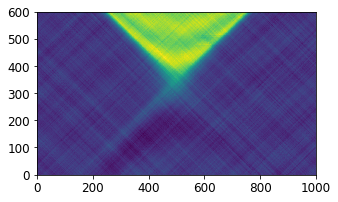

In [17]:
image = np.load('/home/dpirvu/phi070_lambda15/av_thick_bubble_snapshot.npy')
fig, ax = plt.subplots(1, 1, figsize = (5, 3))
im = ax.imshow(image, aspect='auto', interpolation='none', origin='lower')
plt.show()

tmin, tmax 330.0 599.0
hyperbolic trajectories fit:  [495.70955246 341.09769658 586.6023262 ] [491.22486325 326.2381266  777.04659656]


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


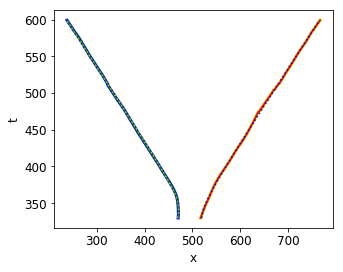

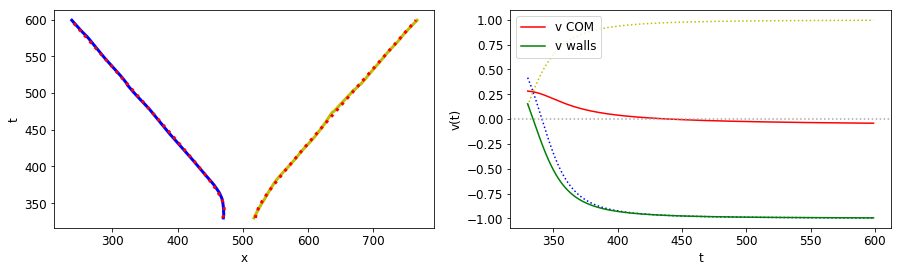

330.0
0.012982953268249275
334.0


In [23]:
beta = velocity(image, True)
